## Iris Dataset Loader with PyTorch

In [34]:
import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Loading the Iris dataset
iris = load_iris()
X = iris.data          # (150, 4)
y = iris.target        # (150,)

# 2. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 4. Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # must be long for CrossEntropyLoss
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 5. Wrap into DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [35]:
X.shape

(150, 4)

In [36]:
y.shape

(150,)

## Step 1: Define the Neural Network

In [37]:
import torch.nn as nn
import torch.nn.functional as f


# Wihtout hidden Layer
class IrisNN(nn.Module):
    def __init__(self):
        super(IrisNN, self).__init__()
        self.linear = nn.Linear(4, 3) # Input 4 features
    def forward(self, x):
        return self.linear(x)

# # With 1 hiddden layer
class IrisNN(nn.Module):
    def __init__(self):
        super(IrisNN, self).__init__()
        self.fc1 = nn.Linear(4,16) # Input 4 features
        self.fc2 = nn.Linear(16,3) # hidden 16
    def forward(self, x):
        x = f.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Step 2: Training Setup

In [38]:
model = IrisNN()

criterion = nn.CrossEntropyLoss()  # combines softmax + cross-entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


## Step 3: Training Loop Using Mini Batch GD

In [39]:
def train(model, loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in loader:
            # Forward
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


In [40]:
train(model, train_loader, criterion, optimizer)

Epoch 10/100, Loss: 0.3973
Epoch 20/100, Loss: 0.4451
Epoch 30/100, Loss: 0.2320
Epoch 40/100, Loss: 0.1807
Epoch 50/100, Loss: 0.2264
Epoch 60/100, Loss: 0.0954
Epoch 70/100, Loss: 0.1131
Epoch 80/100, Loss: 0.1367
Epoch 90/100, Loss: 0.0621
Epoch 100/100, Loss: 0.1638


## Step 4: Evaluate the Model

In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    y_pred = torch.argmax(logits, dim=1)  


print("Accuracy:", accuracy_score(y_test_tensor.numpy(), y_pred.numpy()))

Accuracy: 1.0


In [43]:
print("\nClassification Report:\n")
print(classification_report(y_test_tensor, y_pred, target_names=iris.target_names))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test_tensor, y_pred))


Classification Report:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Confusion Matrix:

[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


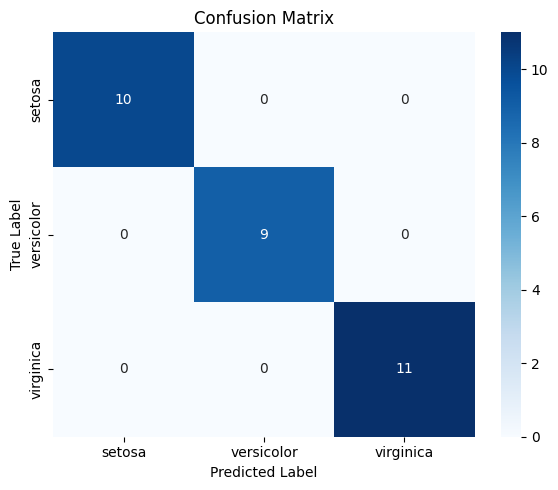

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns  # optional, for better visuals
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_tensor, y_pred)
labels = iris.target_names
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()